In [1]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler, MinMaxScaler, QuantileTransformer
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.pipeline import Pipeline
from os.path import join, exists
from tqdm import tqdm

import pandas as pd
import numpy as np
import traceback
import random
import pickle
import glob
import json
import yaml
import time
import re
import os

from multiprocessing import Pool, cpu_count

from holodecml.vae.checkpointer import *
from holodecml.vae.optimizers import *
from holodecml.vae.tqdm import tqdm

from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import *
import torch.nn.functional as F
from torch import nn
import torch

import matplotlib.pyplot as plt

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")

if is_cuda:
    torch.backends.cudnn.benchmark = True

print(f'Preparing to use device {device}')

Preparing to use device cuda:0


### Load the configuration

In [ ]:
with open("results/9_29/row1/config.yml") as config_file:
    config = yaml.load(config_file, Loader=yaml.FullLoader)

In [ ]:
class LoadGeckoPandas:
    
    def __init__(self, split, data_path, 
                 input_cols, output_cols, 
                 shuffle = True, scaler_x = None, scaler_y = None):
        
        self.data_path = data_path
        self.split = split
        self.input_cols = input_cols
        self.output_cols = output_cols

        self.shuffle = shuffle
        
        self.scaler_x = scaler_x
        self.scaler_y = scaler_y
        
        self.load()
        self.on_epoch_end()
        
    def load(self):
        self.x = pd.read_csv(os.path.join(self.data_path, f"x_{self.split}.csv"))
        self.y = pd.read_csv(os.path.join(self.data_path, f"y_{self.split}.csv"))        
        self.weights = self.y["weight"].copy().to_numpy(dtype=np.float32)
        
        self.x = self.x[self.input_cols].copy()
        self.y = self.y[self.output_cols].copy()
        
        drop_cols = ["index", "id", "indexer"]
        for df in [self.x, self.y]:
            keep_cols = [x for x in df.columns if x not in drop_cols]
            df = df[keep_cols].copy()
            
        if self.scaler_x is not None and self.scaler_y is not None:
            self.x = self.scaler_x.transform(
                self.x.drop(['Time [s]', 'id'], axis=1)
            )
            self.y = self.scaler_y.transform(
                self.y.drop(['Time [s]', 'id'], axis=1)
            )
        else:
            self.scaler_x = Pipeline(
                steps=[('quant', QuantileTransformer()), ('minmax', MinMaxScaler((0, 1)))]
            )
            self.scaler_y = Pipeline(
                steps=[('quant', QuantileTransformer()), ('minmax', MinMaxScaler((0, 1)))]
            )
            self.x = self.scaler_x.fit_transform(
                self.x.drop(['Time [s]', 'id'], axis=1)
            )
            self.y = self.scaler_y.fit_transform(
                self.y.drop(['Time [s]', 'id'], axis=1)
            )
            with open(os.path.join(self.data_path, "scalers.pkl"), "wb") as fid:
                pickle.dump([self.scaler_x, self.scaler_y], fid)
                
    def get_transform(self):
        return self.scaler_x, self.scaler_y
        
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        
        self.processed += 1
        if self.processed == self.__len__():
            self.on_epoch_end()
        
        x_data = torch.from_numpy(self.x[idx].astype(np.float32))
        y_data = torch.from_numpy(self.y[idx].astype(np.float32))
        w_data = np.array([self.weights[idx].astype(np.float32)])
        w_data = torch.from_numpy(w_data)
        
        return x_data, y_data, w_data
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.processed = 0
        if self.shuffle == True:
            pass

### Create the train, test, val splits

In [5]:
random.seed(5000)

In [6]:
train_data_set = LoadGeckoPandas(
    split = "train",
    **config["data"]
)

config["data"]["shuffle"] = False

In [7]:
valid_data_set = LoadGeckoPandas(
    split = "val",
    **config["data"],
    scaler_x = train_data_set.scaler_x,
    scaler_y = train_data_set.scaler_y 
)

In [8]:
test_data_set = LoadGeckoPandas(
    split = "test",
    **config["data"],
    scaler_x = train_data_set.scaler_x,
    scaler_y = train_data_set.scaler_y 
)

### Initialize iterators

In [9]:
#logging.info(f"Loading training data iterator using {config['iterator']['num_workers']} workers")
    
train_dataloader = DataLoader(
    train_data_set,
    **config["iterator"]
)

valid_dataloader = DataLoader(
    valid_data_set,
    **config["iterator"]
)

test_dataloader = DataLoader(
    test_data_set,
    **config["iterator"]
)

### Model

In [8]:
class DenseNet(nn.Module):

    def __init__(self, 
                 input_size, 
                 output_size, 
                 hidden_dims = [100, 50], 
                 dropouts = [0.2, 0.2]):
        
        super(DenseNet, self).__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        
        #self.embedding = nn.Embedding(train_data_set.num_timesteps, 16)
        
        self.model = [
            nn.Linear(input_size, hidden_dims[0]),
            #nn.BatchNorm1d(num_features=hidden_dims[0]),
            nn.LeakyReLU()
        ]
        if len(hidden_dims) > 1:
            if dropouts[0] > 0.0:
                self.model.append(nn.Dropout(dropouts[0]))
            for i in range(len(hidden_dims)-1):
                self.model.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
                #self.model.append(nn.BatchNorm1d(num_features=hidden_dims[i+1]))
                self.model.append(nn.LeakyReLU())
                if dropouts[i+1] > 0.0:
                    self.model.append(nn.Dropout(dropouts[i+1]))
        self.model.append(nn.Linear(hidden_dims[-1], output_size))
        self.model.append(nn.Sigmoid())
        self.model = nn.Sequential(*self.model)

    def forward(self, x):
        #x1, x2 = x
        #x1 = self.embedding(x1)
        #x = torch.cat([x1, x2], 1)
        x = self.model(x)
        return x

In [22]:
model = DenseNet(**config["model"])

In [23]:
model

DenseNet(
  (model): Sequential(
    (0): Linear(in_features=35, out_features=10000, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=10000, out_features=29, bias=True)
    (3): Sigmoid()
  )
)

In [24]:
if is_cuda:
    model = model.to(device)

In [25]:
optimizer = LookaheadDiffGrad(model.parameters(),
                              lr=config["optimizer"]["lr"])
                              #weight_decay=1e-5)

In [26]:
# # Measure allocated memory after the call
# torch.cuda.synchronize()
# end_max_memory = torch.cuda.max_memory_allocated() / 1024**2
# end_memory = torch.cuda.memory_allocated() / 1024**2

class BaseTrainer:
    
    def __init__(self, 
                 model, 
                 optimizer,
                 train_gen, 
                 valid_gen, 
                 dataloader, 
                 valid_dataloader,
                 start_epoch = 0,
                 epochs = 100,
                 timesteps = 1439,
                 window_size = 10,
                 teacher_force = True,
                 gamma = 0.5,
                 device = "cpu",
                 clip = 1.0,
                 path_save = "./"):
        
        self.model = model
        self.outsize = model.output_size
        self.optimizer = optimizer
        self.train_gen = train_gen
        self.valid_gen = valid_gen
        self.dataloader = dataloader
        self.valid_dataloader = valid_dataloader
        self.batch_size = dataloader.batch_size
        self.path_save = path_save
        self.device = device
        
        self.start_epoch = start_epoch 
        self.epochs = epochs
        self.window_size = window_size
        
        self.teacher_force = teacher_force
        self.gamma = gamma
        
        #self.criterion = nn.MSELoss()
        
        timesteps = timesteps
        self.time_range = list(range(timesteps))
                
        # Gradient clipping through hook registration
        for p in self.model.parameters():
            p.register_hook(lambda grad: torch.clamp(grad, -clip, clip))
        logger.info(f"Clipping gradients to range [-{clip}, {clip}]")
        
        # Create the save directory if it does not exist
        try:
            os.makedirs(path_save)
        except:
            pass
        
    def WMSE(self, y_true, y_pred, weights = []):
        if len(weights) > 0:
            mse = torch.mean(weights * (y_true - y_pred) ** 2)
        else:
            mse = torch.mean((y_true - y_pred) ** 2)
        return mse
        
    def criterion(self, y_true, y_pred, weights = []):
                        
        y_true_precursor = y_true[:, 0]
        y_pred_precursor = y_pred[:, 0]
        
        y_true_gas = y_true[:, 1:15]
        y_pred_gas = y_pred[:, 1:15]
        
        y_true_aero = y_true[:, 15:]
        y_pred_aero = y_pred[:, 15:]
        
        mse_precursor = self.WMSE(y_true_precursor, y_pred_precursor, weights)
        mse_gas = self.WMSE(y_true_gas, y_pred_gas, weights)
        mse_aero = self.WMSE(y_true_aero, y_pred_aero, weights)
        mse = mse_precursor + mse_gas + mse_aero
        
        kld_gas = nn.KLDivLoss()(
            F.log_softmax(y_pred_gas),
            F.softmax(y_true_gas)
        )
        kld_aero = nn.KLDivLoss()(
            F.log_softmax(y_pred_aero),
            F.softmax(y_true_aero)
        )

        return mse + (kld_gas + kld_aero)
        
    def train_one_epoch(self, epoch, steps = 100):
        
        self.model.train()
        batches_per_epoch = int(np.ceil(self.train_gen.__len__() / self.batch_size))
        
        if batches_per_epoch > steps:
            batches_per_epoch = steps
        
        batch_group_generator = tqdm(
            self.dataloader,
            total=batches_per_epoch, 
            leave=True
        )
    
        epoch_losses = {"loss": []}
        for batch_idx, (x, y, w) in enumerate(batch_group_generator):
            x = x.to(device)
            y = y.to(device)
            w = w.to(device)

            y_pred = self.model(x)
            loss = self.criterion(y, y_pred, w)   
            epoch_losses["loss"].append(loss.item())

            # backprop after experiment
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # update tqdm
            to_print = "loss: {:.3f}".format(np.mean(epoch_losses["loss"]))
            batch_group_generator.set_description(to_print)
            batch_group_generator.update()
            
            if (batch_idx + 1) % steps == 0:
                break
            
        return np.mean(epoch_losses["loss"])
            
    def test(self, epoch):

        self.model.eval()
        batches_per_epoch = int(np.ceil(self.valid_gen.__len__() / self.batch_size))

        with torch.no_grad():

            batch_group_generator = tqdm(
                self.valid_dataloader,
                total=batches_per_epoch, 
                leave=True
            )
            
            epoch_losses = {"loss": []}
            for (x, y, w) in batch_group_generator:
                x = x.to(device)
                y = y.to(device)
                y_pred = self.model(x)
                loss = self.criterion(y, y_pred)
                epoch_losses["loss"].append(loss.item())

                # update tqdm
                to_print = "val_loss: {:.3f}".format(np.mean(epoch_losses["loss"]))
                batch_group_generator.set_description(to_print)
                batch_group_generator.update()
            
        return np.mean(epoch_losses["loss"]) 
    
    
    def train(self,
              scheduler,
              early_stopping,
              metrics_logger):
        
        logger.info(
            f"Training the model for up to {self.epochs} epochs starting at epoch {self.start_epoch}"
        )
        
        flag = isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau)
        
        for epoch in range(self.start_epoch, self.epochs):
            train_loss = self.train_one_epoch(epoch)
            test_loss = self.test(epoch)

            scheduler.step(test_loss if flag else epoch)
            early_stopping(epoch, test_loss, self.model, self.optimizer)

            # Write results to the callback logger 
            result = {
                "epoch": epoch,
                "train_loss": train_loss,
                "valid_loss": test_loss,
                "lr": early_stopping.print_learning_rate(self.optimizer),
                "teacher_forcing_score": self.tf_annealer(epoch) if self.teacher_force else 1.0
            }
            metrics_logger.update(result)

            if early_stopping.early_stop:
                logger.info("Early stopping")
                break

    def tf_annealer(self, epoch):
        return 1.0 * self.gamma ** epoch # 1/(1 + self.decay * epoch) 

In [27]:
trainer = BaseTrainer(
    model, 
    optimizer,
    train_data_set, 
    valid_data_set, 
    train_dataloader, 
    valid_dataloader,
    device = device,
    **config["trainer"]
)

In [28]:
# Initialize LR annealing scheduler 
if "ReduceLROnPlateau" in config["callbacks"]:
    schedule_config = config["callbacks"]["ReduceLROnPlateau"]
    scheduler = ReduceLROnPlateau(trainer.optimizer, **schedule_config)
    #logging.info(
    #    f"Loaded ReduceLROnPlateau learning rate annealer with patience {schedule_config['patience']}"
    #)
elif "ExponentialLR" in config["callbacks"]:
    schedule_config = config["callbacks"]["ExponentialLR"]
    scheduler = ExponentialLR(trainer.optimizer, **schedule_config)
    #logging.info(
    #    f"Loaded ExponentialLR learning rate annealer with reduce factor {schedule_config['gamma']}"
    #)

# Early stopping
checkpoint_config = config["callbacks"]["EarlyStopping"]
early_stopping = EarlyStopping(**checkpoint_config)

# Write metrics to csv each epoch
metrics_logger = MetricsLogger(**config["callbacks"]["MetricsLogger"])

In [29]:
#torch.autograd.set_detect_anomaly(True)

In [35]:
trainer.train(scheduler, early_stopping, metrics_logger)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch   968: reducing learning rate of group 0 to 2.0000e-06.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch   975: reducing learning rate of group 0 to 4.0000e-07.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch   980: reducing learning rate of group 0 to 8.0000e-08.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch   982: reducing learning rate of group 0 to 1.6000e-08.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch   984: reducing learning rate of group 0 to 3.2000e-09.


val_loss: 0.000: 100%|██████████| 282/282 [00:03<00:00, 93.47it/s] 


In [2]:
f = pd.read_csv("results/9_29/row1/training_log.csv")

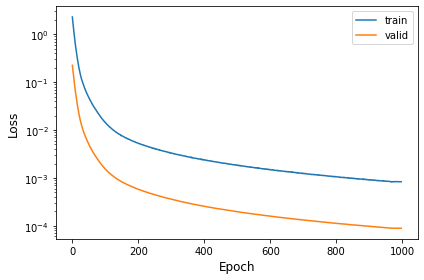

In [3]:
plt.semilogy(f.index, f["train_loss"])
plt.semilogy(f.index, f["valid_loss"])

plt.xlabel("Epoch", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)

plt.legend(["train", "valid"])
plt.tight_layout()

### Predict with the best model

In [4]:
class LoadGeckoPandasExperiment:
    
    def __init__(self, data_path, input_cols, output_cols, experiment_subset = False):
        
        self.data_path = data_path
        self.input_cols = input_cols
        self.output_cols = output_cols  
        self.experiment_subset = experiment_subset
        self.load()
    
    def load(self):
        self.x = pd.read_csv(os.path.join(self.data_path, "row_data_in.csv"))
        self.y = pd.read_csv(os.path.join(self.data_path, "row_data_out.csv"))
        
        drop_cols = ["index", "indexer"]
        for df in [self.x, self.y]:
            keep_cols = [x for x in df.columns if x not in drop_cols]
            df = df[keep_cols].copy()
            
        if self.experiment_subset:
            cond1 = self.x['id'].isin(self.experiment_subset)
            cond2 = self.y['id'].isin(self.experiment_subset)
            self.x = self.x[cond1].copy()
            self.y = self.y[cond2].copy()
        
        self.x_dict = {
            experiment: group for (experiment, group) in self.x.groupby(["id"])
        }
        self.y_dict = {
            experiment: group for (experiment, group) in self.y.groupby(["id"])
        }
        self.w_dict = {
            experiment: group["weight"] for (experiment, group) in self.y_dict.items()
        }
        
        with open(os.path.join(self.data_path, "scalers.pkl"), "rb") as fid:
            self.scaler_x, self.scaler_y = pickle.load(fid)
               
        self.x_dict = {
            experiment: self.scaler_x.transform(
                group[self.input_cols].drop(['Time [s]', 'id'], axis=1)
            ) 
            for (experiment, group) in self.x_dict.items()
        }
        self.y_dict = {
            experiment: self.scaler_y.transform(
                group[self.output_cols].drop(['Time [s]', 'id'], axis=1)
            ) 
            for (experiment, group) in self.y_dict.items()
        }
        
    def __len__(self):
        return len(self.x_dict)
    
    def __getitem__(self, idx):
        
        X = self.x_dict[f"Exp{idx}"]
        Y = self.y_dict[f"Exp{idx}"]
        W = self.w_dict[f"Exp{idx}"]
        
        for (x, y, w) in zip(X, Y, W):
            x_data = torch.from_numpy(x.astype(np.float32))
            y_data = torch.from_numpy(y.astype(np.float32))
            w_data = torch.from_numpy(np.array([w]))
            yield (x_data, y_data, w_data)

In [5]:
with open("results/9_29/row1/config.yml") as config_file:
    config = yaml.load(config_file, Loader=yaml.FullLoader)

In [6]:
input_vars = config["data"]["input_cols"]
output_vars = config["data"]["output_cols"]

t = LoadGeckoPandasExperiment("clustered/row_data", input_vars, output_vars)

In [9]:
model = DenseNet(**config["model"])

In [10]:
model_dict = torch.load("results/9_29/row1/best.pt", 
                        map_location=lambda storage, loc: storage)
model.load_state_dict(model_dict["model_state_dict"])

<All keys matched successfully>

In [11]:
model.eval()

DenseNet(
  (model): Sequential(
    (0): Linear(in_features=35, out_features=10000, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=10000, out_features=29, bias=True)
    (3): Sigmoid()
  )
)

In [12]:
device = "cpu"
model = model.to(device)

In [13]:
loss, y_pred, y_true = [], [], []

for (x,y,w) in tqdm(t.__getitem__(0)):
    x = x.view(1, x.size(0)).to(device)
    y = y.view(1, y.size(0)).to(device)
    w = w.to(device)
    
    next_x = model(x)
    y_pred.append(next_x)
    y_true.append(y)    

1439it [00:00, 3420.94it/s]


In [31]:
loss, y_pred, y_true = [], [], []

for k, (x,y,w) in tqdm(enumerate(t.__getitem__(0))):
    x = x.view(1, x.size(0)).to(device)
    y = y.view(1, y.size(0)).to(device)
    w = w.to(device)
    
    #X = x
    if k == 0:
        X = x
    
    next_x = model(X)
    #loss.append(RMSELoss()(next_x, y[:,t]))
    
    y_pred.append(next_x)
    y_true.append(y) 
    
    X[:, :model.output_size] = next_x
    
# #loss = torch.mean(torch.stack(loss))
# preds = torch.stack(preds, axis = -1).permute(0, 2, 1)

1439it [00:00, 3007.18it/s]


In [32]:
def quantities(Y):
    a, b, c = [], [], []
    for y in Y:
        y = y[0, :]
        prec = y[0]
        gas = y[1:15].sum(-1)/14
        aero = y[15:].sum(-1)/14
        a.append(prec.item())
        b.append(gas.item())
        c.append(aero.item())
    return a, b, c

In [33]:
prec_pred, gas_pred, aero_pred = quantities(y_pred)
prec_true, gas_true, aero_true = quantities(y_true)

(0.0, 1.01)

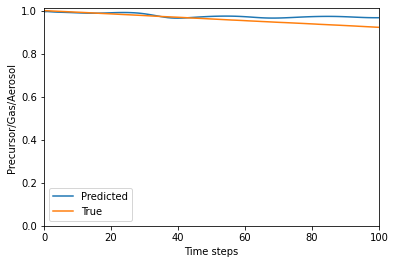

In [39]:
plt.plot(range(len(prec_pred)), prec_pred)
plt.plot(range(len(prec_pred)), prec_true)

plt.legend(["Predicted", "True"])

plt.ylabel("Precursor/Gas/Aerosol")
plt.xlabel("Time steps")

plt.xlim([0.0, 100])
plt.ylim([0.0, 1.01])

(0.0, 1.01)

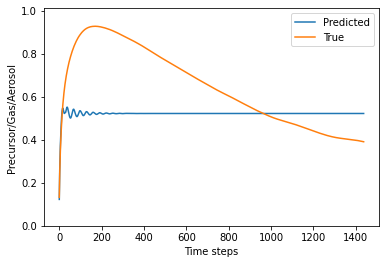

In [38]:
plt.plot(range(len(prec_pred)), gas_pred)
plt.plot(range(len(prec_pred)), gas_true)

plt.legend(["Predicted", "True"])

plt.ylabel("Precursor/Gas/Aerosol")
plt.xlabel("Time steps")

plt.ylim([0.0, 1.01])

(0.0, 1.01)

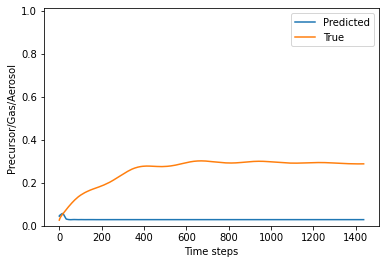

In [36]:
plt.plot(range(len(prec_pred)), aero_pred)
plt.plot(range(len(prec_pred)), aero_true)

plt.legend(["Predicted", "True"])

plt.ylabel("Precursor/Gas/Aerosol")
plt.xlabel("Time steps")

plt.ylim([0.0, 1.01])